<p style="text-align:center; font-size:x-large; color:black;">MA(q) Models</p>
<hr>

In this file, I will try to fit a __ Moving Average (MA)__ model on the trading volumes of T-Mobile (NYSE: TMUS). High trading volume generally indicates increased market activity and interest in a particular asset, so it may be of use if we can develop a prediction of what future trading volumes are going to be. <br><br>
Before going further, I am going to grab some stock data with the YahooFinance API.

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf

In [3]:
msft = yf.Ticker("TMUS")
data = msft.history(period="3y")
data = data.drop(columns = ['Open', 'High', 'Low', 'Close', 'Dividends', 'Stock Splits'])
data.index = range(len(data))
data

,Volume
0,2721700
1,3008600
2,2011400
3,3401800
4,4138400
...,...
750,3246600
751,5005900
752,3701900
753,4165100


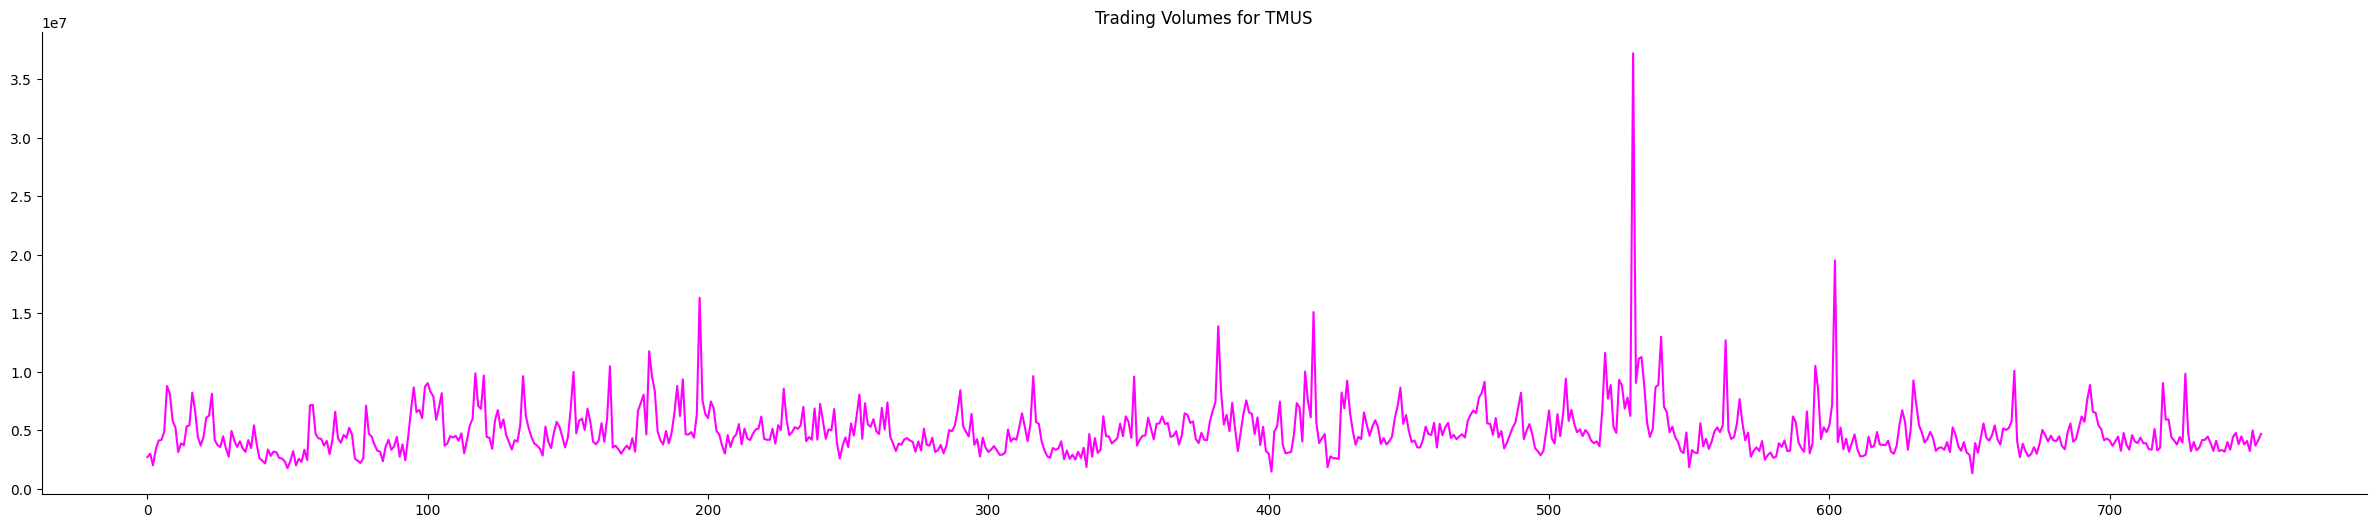

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30,6))
plt.plot(data.index, data['Volume'], color = 'magenta')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('Trading Volumes for TMUS')
plt.show()

Similar to the __AR(p) Models__ file, I'm going to split my data into training and testing, and fit the time-series model on the training data.

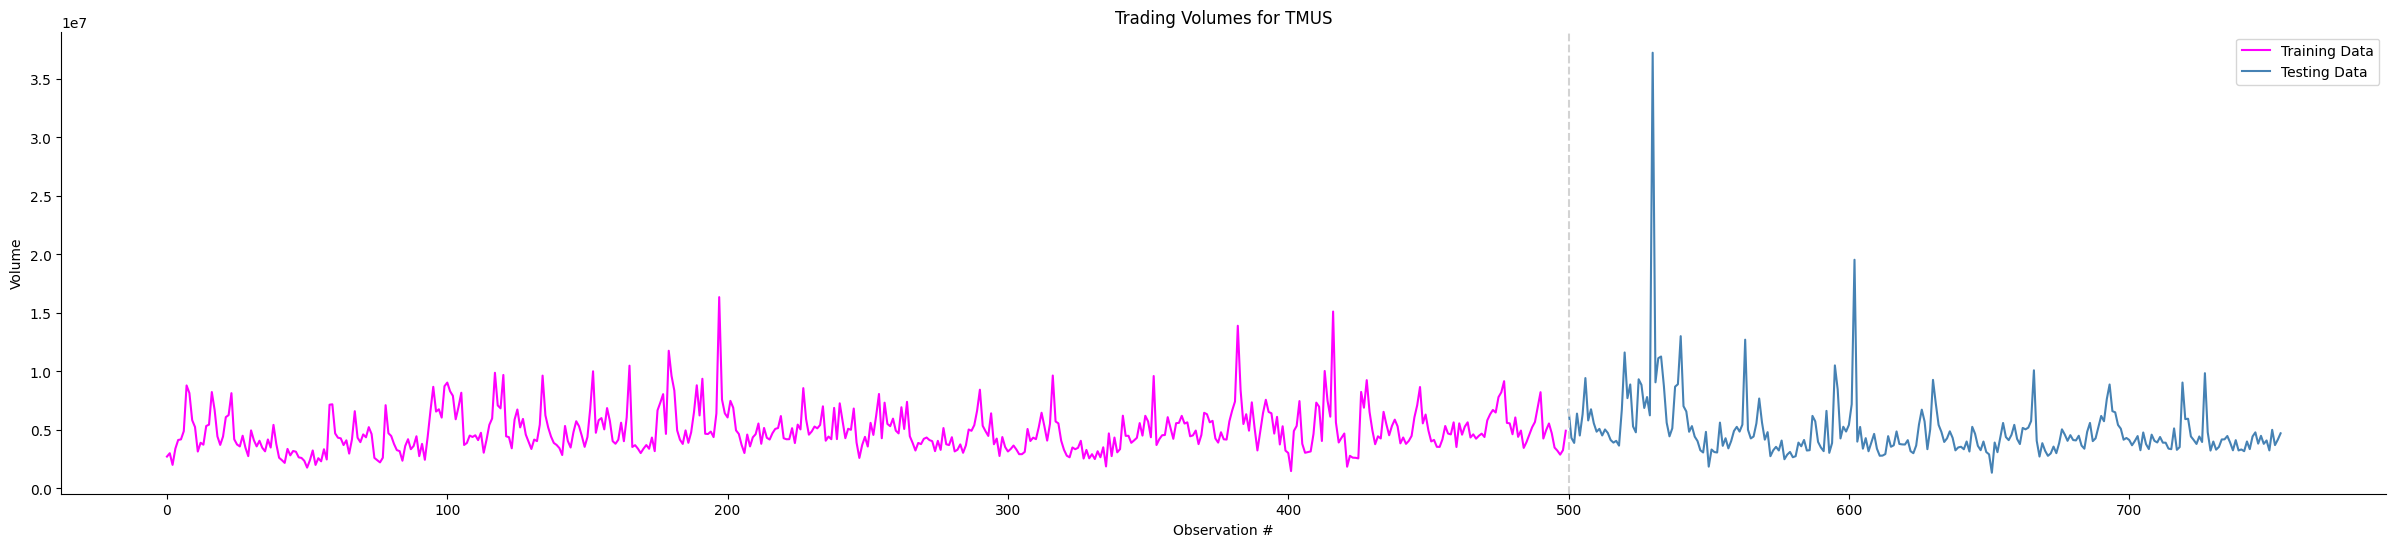

In [5]:
training_data = data.iloc[:500]
testing_data = data.iloc[500:]

fig = plt.figure(figsize = (30,6))
plt.plot(training_data.index, training_data['Volume'], color = 'magenta', label = 'Training Data')
plt.plot(testing_data.index, testing_data['Volume'], color = 'steelblue', label = 'Testing Data')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('Trading Volumes for TMUS')
plt.xlabel('Observation #')
plt.legend()
plt.axvline(500, color = 'lightgray', linestyle = '--')
plt.ylabel('Volume')
plt.show()

<p style="text-align:left; font-size:x-large; color:black;">The Math Behind MA(q) Models</p>

An MA model is a type of stationary time series model where the current value is based on its previous error terms. We can imagine it as a multiple (or single) linear regression over time, where our predictor variables are previous errors. The lag __q__ denotes how many past errors we are using at predictors for this regression. In equational form, an MA(q) model is the following...

$$
r_{t} = \mu + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \theta_{2}\epsilon_{t-2} + \cdots + \theta_{q}\epsilon_{t-q}
$$

Each &epsilon;<sub>i</sub> is a random value drawn from a __White Noise__ process. A white noise process is a sequence of random variables with mean 0 and finite variance, that have no correlation between successive values. In other words, there is no way of predicting future values of &epsilon;<sub>t</sub>. We can imagine this as the residuals of a linear regression over time. <br><br>
It's in the word itself, but stationary time-series models like MA(q), AR(p), and ARMA(p,q) are __weak stationarity__. This means that the mean and variance of our process is invariant of time. In other words,
$$
E[r_{t}] = E[r_{t - 1}] = E[r_{t - 2}] = \cdots
$$
$$
var[r_{t}] = var[r_{t - 1}] = var[r_{t - 2}] = \cdots
$$
Through some manupulation and the requirement of weak stationarity, we can develop an overall expecation and variance for the process r<sub>t</sub>.
$$
E[r_{t}] = \mu
$$
$$
Var[r_t] = \sigma_{\epsilon}^{2}\left(\theta_{1}^{2} + \theta_{2}^{2} + \cdots + \theta_{q}^{2}\right)
$$
Since our model coefficients (&mu;,&theta;s) aren't changing, these formulas for the mean and variance of our MA(q) process show weak stationarity.

<p style="text-align:left; font-size:x-large; color:black;"> ACFs </p>

When fitting an MA(q) process to a time-series, we don't know what the order (q) is yet. To determine q, it's useful to look at the __Auto-Correlation Function (PACF)__ values. The autocorrelation tells us the direct relationship between a specific time point in a time series and its lagged values. In other words...

$$
\text{Autocorrelation for lag k} = Corr(r_{t}, r_{t - k})
$$

Since an MA(q) model is essentially a regression on the p past errors, the autocorrelation for any lag beyond p should be 0. Therefore, to determine the order of our MA model, we should examine the ACF plot and see where the ACF values abruptly become insignificant.

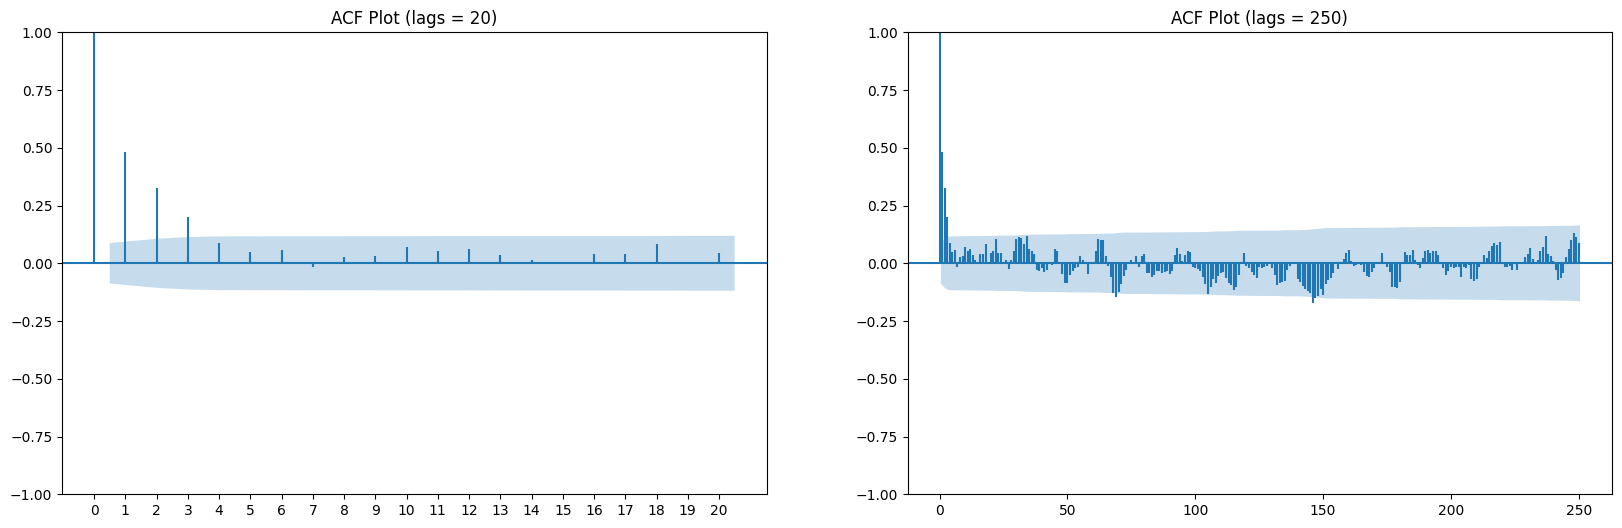

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

T = len(training_data)

fig, ax = plt.subplots(1,2,figsize = (20,6))
plot_acf(training_data['Volume'], marker = None, lags = 20, ax = ax[0])
ax[0].set_xticks(range(21))
ax[0].set_title('ACF Plot (lags = 20)')

plot_acf(training_data['Volume'], marker = None, lags = T/2, ax = ax[1])
ax[1].set_title('ACF Plot (lags = 250)')

plt.show()

We can see that the significant partial autocorrelations (above the bars) drop off after lag 3. This suggests that we can try to implement an MA(3) process to model the training data. We can also use a special python function to figure out which order is the most ideal. Unfortunately, there is no built-in function in Python that automatically picks the best MA order.

After deciding the number of lags we want to use, we can now fit an AR model using python's __ARIMA__ model. This takes in 3 parameters: p (the auto-regressive order), d (the differencing order), and q (the moving average order). Since we are only fitting an MA(3) model, our order will be (0, 0, 3).

In [11]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(training_data['Volume'], order=(0, 0, 3)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  500
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -7854.563
Date:                Wed, 24 Apr 2024   AIC                          15719.126
Time:                        21:45:03   BIC                          15740.200
Sample:                             0   HQIC                         15727.396
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.937e+06   1.48e+05     33.369      0.000    4.65e+06    5.23e+06
ma.L1          0.4190      0.039     10.831      0.000       0.343       0.495
ma.L2          0.2963      0.053      5.623      0.0

Instead of relying on a pre-built python function, I am first going to define my own method to predict future values to show what's going on.
$$
r_{t} = \mu + \epsilon_{t} + \theta_{1}\epsilon_{t-1} + \theta_{2}\epsilon_{t-2} + \cdots + \theta_{q}\epsilon_{t-q}
$$

$$
E[r_{t} | \epsilon_{t-1} \cdots \epsilon_{t-q}] = \hat{r_{t}} = \mu + \theta_{1}\epsilon_{t-1} + \theta_{2}\epsilon_{t-2} + \cdots + \theta_{q}\epsilon_{t-q} = \mu + 

\begin{pmatrix}
\theta_{1} \\
\vdots \\
\theta_{q} \\
\end{pmatrix}
\cdot 
\begin{pmatrix}
\epsilon_{t-1} \\
\vdots \\
\epsilon_{t-q} \\
\end{pmatrix}
$$

In [8]:
# Training Data Forecasts
rhats = []
errors = np.zeros(3) # Need to keep track of errors as well.

# First get rid of terms where p-values > 0.05
for j in range(len(model.pvalues)):

    if model.pvalues.iloc[j] > 0.05:
        model.params.iloc[j] = 0
    
const = model.params.iloc[0]
regressor_coefs = model.params.iloc[1: len(model.params) - 1].values
MA_order = 3

# Now re-iterate predictions based on ACTUAL data
for i in range(MA_order, len(training_data)):
    
    rhat = const + np.dot(regressor_coefs, errors)
    error = training_data.iloc[i].values[0] - rhat
    errors[2] = errors[1]
    errors[1] = errors[0]
    errors[0] = error

    rhats.append(rhat)

rhats = pd.Series(rhats)
rhats.index = range(MA_order, len(training_data))

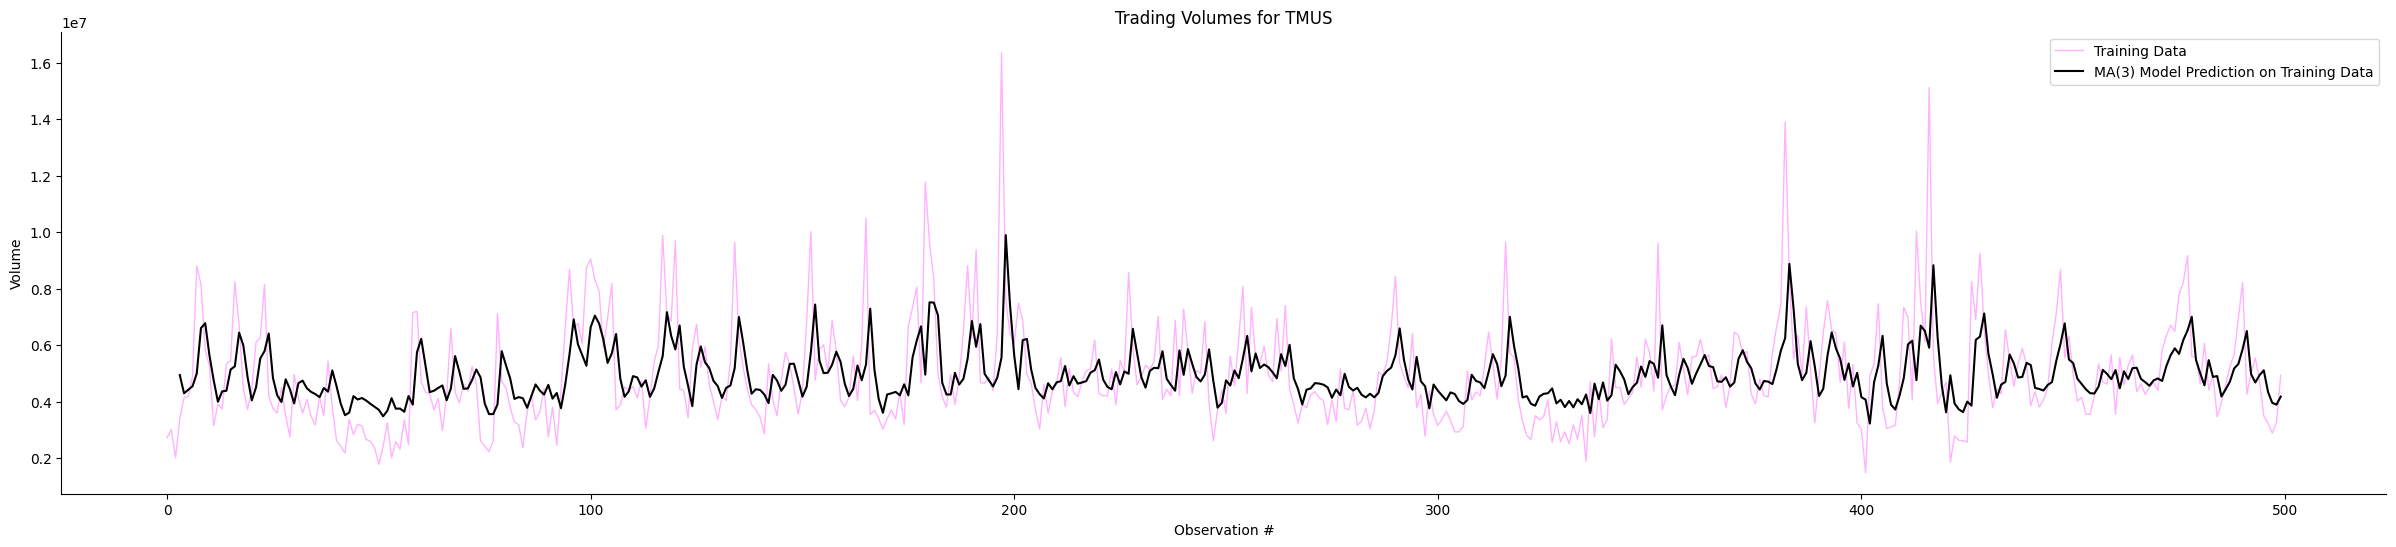

In [9]:
fig = plt.figure(figsize = (30,6))
plt.plot(training_data.index, training_data['Volume'], color = 'magenta', linewidth = 1, alpha = 0.3, label = 'Training Data')
plt.plot(rhats.index, rhats, color = 'black', label = 'MA(3) Model Prediction on Training Data')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('Trading Volumes for TMUS')
plt.xlabel('Observation #')
plt.legend()
plt.ylabel('Volume')
plt.show()

<p style="text-align:left; font-size:x-large; color:black;">Residual Analysis</p>

I explained how to perform residual analysis of a time-series on the __AR(p) Models__ file, so I will just perform them here.

First, I check if the mean of the residuals is most likely 0 through a __one-sample T-Test__.

In [19]:
from scipy import stats

residuals = (training_data['Volume'].iloc[MA_order:] - rhats).values

t_test_result = stats.ttest_1samp(residuals, 0)

print(f'P-Value = {t_test_result[1]}')


P-Value = 0.9142672574275775


The one-sample T-Test implicates that the mean of our residuals are likely zero, even though we noticed a non-zero mean.

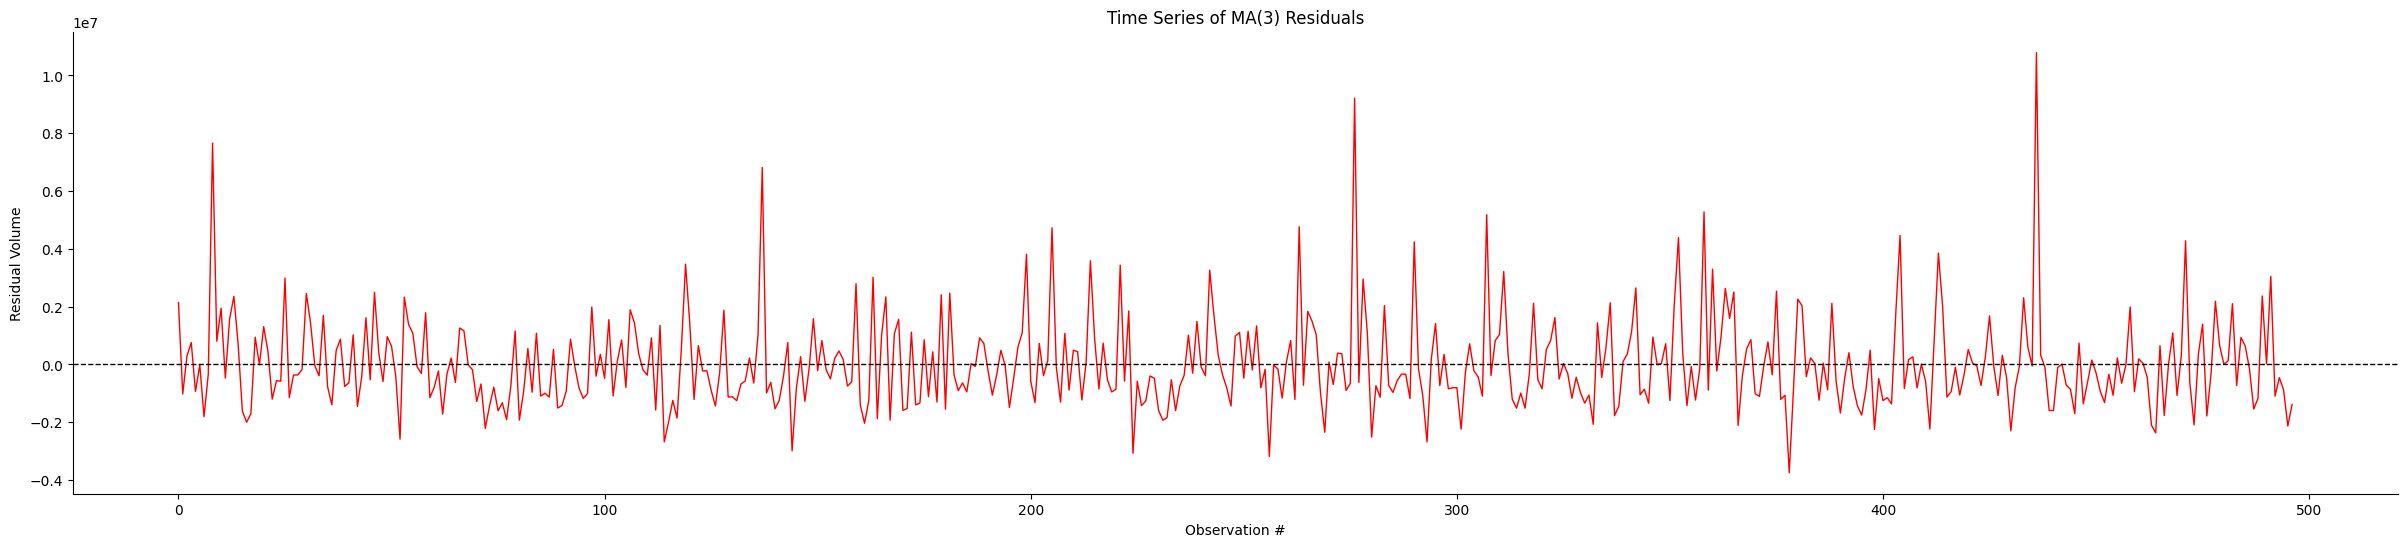

In [24]:
fig = plt.figure(figsize = (30,6))
plt.plot(residuals, color = 'red', linewidth = 1)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title('Time Series of MA(3) Residuals')
plt.xlabel('Observation #')
plt.ylabel('Residual Volume')
plt.axhline(0, color = 'black', linestyle = '--', linewidth = 1)
plt.show()

To check for constant variance a.k.a homoscedacity, we use the __Breusch-Pagan__ test.

In [23]:
from statsmodels.stats.diagnostic import het_arch

lm, lm_p_value, fvalue, f_p_value = het_arch(residuals)
f_p_value

0.9810054857545356

Now we can say that the variance of our residuals are time-invariant.

Next, I'll check if my residuals are identically distributed with the __Kolmogorov-Smirnov__ test.

In [21]:
from scipy import stats

# Split the residuals array into two random samples
residuals_copy = residuals
np.random.shuffle(residuals_copy)

sample1 = residuals_copy[:len(residuals_copy)//2]
sample2 = residuals_copy[len(residuals_copy)//2:]

# Perform KS Test
ks_statistic, p_value = stats.ks_2samp(sample1, sample2)
p_value

0.824048886696864

We can conclude that our residuals are identically distributed.

Next, we'll check if the residuals are independent through the __Ljung-Box__ test.

In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test_results = acorr_ljungbox(residuals, lags = 30)
lb_test_results

,lb_stat,lb_pvalue
1,0.316747,0.573569
2,0.510473,0.774733
3,0.532966,0.911592
4,1.989294,0.737728
5,2.268511,0.810881
6,2.379268,0.881727
7,2.442322,0.931377
8,6.174808,0.627658
9,6.288639,0.710719
10,6.356640,0.784463


We can conclude that the residuals are most likely independent.

We have now checked all the assumptions for a white-noise process, and can conclude that the residuals of our MA(3) process are white noise. Therefore, we can safely model the trading volumes of TMUS with a MA(3) model.

<p style="text-align:left; font-size:x-large; color:black;">Out-of-Sample Forecasts</p>

In [31]:
# Training Data Forecasts
rhats = []
errors = np.zeros(3) # Need to keep track of errors as well.

# First get rid of terms where p-values > 0.05
for j in range(len(model.pvalues)):

    if model.pvalues.iloc[j] > 0.05:
        model.params.iloc[j] = 0
    
const = model.params.iloc[0]
regressor_coefs = model.params.iloc[1: len(model.params) - 1].values
MA_order = 3

# Now re-iterate predictions based on ACTUAL data
for i in range(len(testing_data)):
    
    rhat = const + np.dot(regressor_coefs, errors)
    error = data.iloc[len(training_data) + i - 1].values[0] - rhat
    errors[2] = errors[1]
    errors[1] = errors[0]
    errors[0] = error

    rhats.append(rhat)

rhats = pd.Series(rhats)
rhats.index = testing_data.index

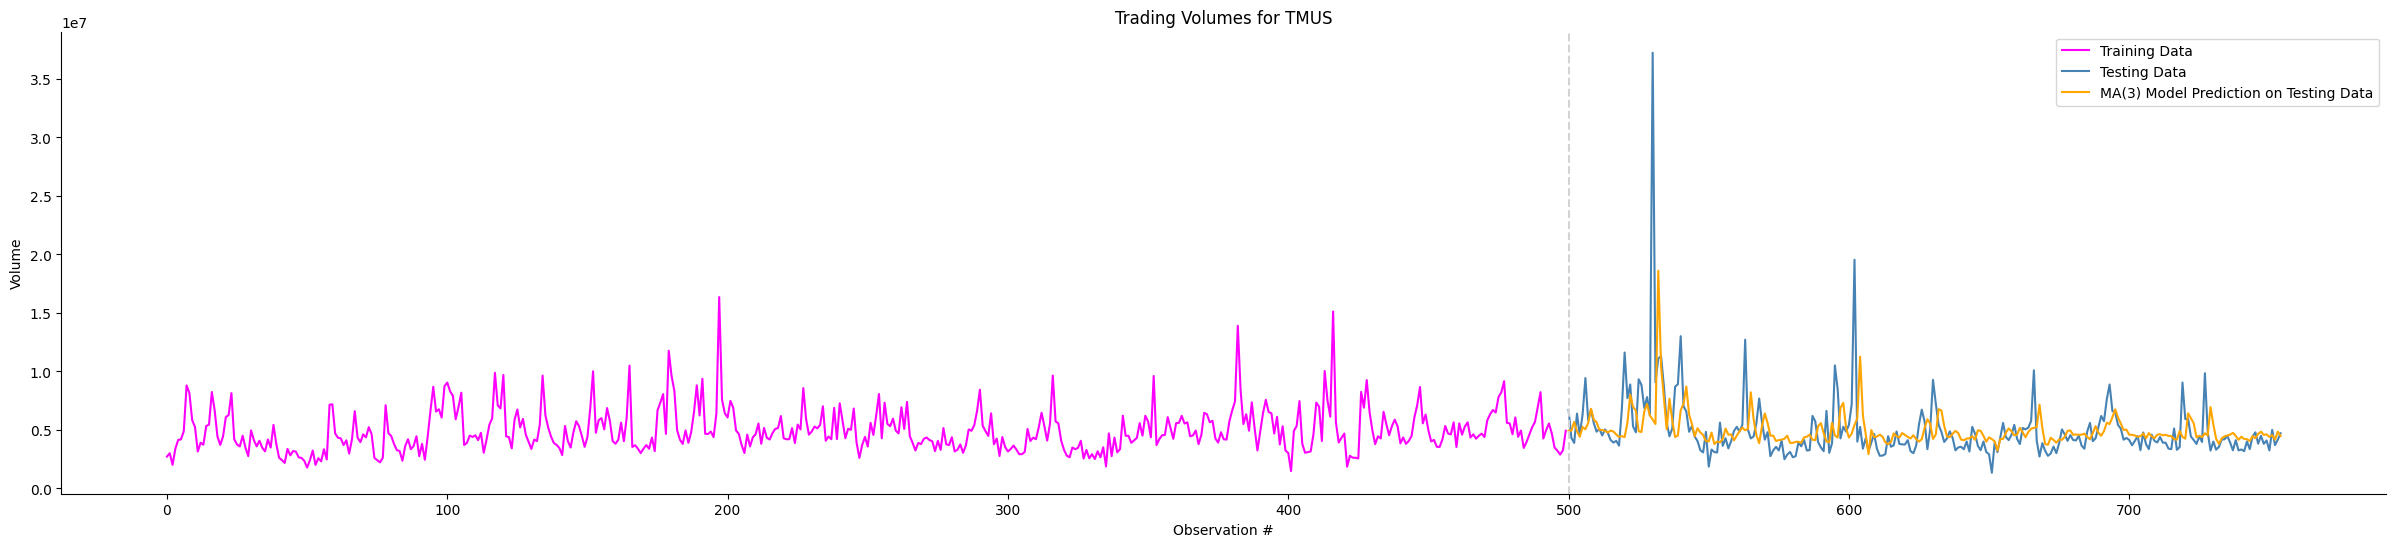

In [33]:
fig = plt.figure(figsize = (30,6))
plt.plot(training_data.index, training_data['Volume'], color = 'magenta', label = 'Training Data')
plt.plot(testing_data.index, testing_data['Volume'], color = 'steelblue', label = 'Testing Data')
plt.plot(rhats.index, rhats, color = 'orange', label = 'MA(3) Model Prediction on Testing Data')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title('Trading Volumes for TMUS')
plt.xlabel('Observation #')
plt.legend()
plt.axvline(500, color = 'lightgray', linestyle = '--')
plt.ylabel('Volume')
plt.show()

If we compare this to our AR(2) model from the __AR(p) Models__, we will see a much better fit.

In [37]:
residuals = (data['Volume'].iloc[len(training_data):] - rhats).values
print(np.mean(residuals))

23655.896224076958


Now that we know it's appropriate to use an MA(3) model to model Trading Volumes for TMUS, we can calculate some useful model metrics.

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = data['Volume'].iloc[len(training_data):]
y_pred = rhats

mse = mean_squared_error(y_pred, y_true)
mae = mean_absolute_error(y_pred, y_true)
mape = np.mean(np.abs((y_pred - y_true) / y_true)) * 100

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape}%')

Mean Squared Error: 8043232605047.923
Root Mean Squared Error: 2836059.344415755
Mean Absolute Error: 1433946.9823344653
Mean Absolute Percentage Error: 27.055573864144613%
